<a href="https://colab.research.google.com/github/sainikhila11/INFO5731-Group2-FinalProject/blob/main/Saketh_MedRed_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install openai==0.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.1 MB/s eta 0:00:00


**Subreddit vs Post**

In [ ]:
import pandas as pd
import openai
from scipy.spatial.distance import cosine
from tqdm import tqdm  # Progress tracking

# Assign your OpenAI API key
openai.api_key = 'sk-proj-FFgXXrjrERWxO4z2XsjAT3BlbkFJAa2ZiweUp6plh5Kioaav'

# Set the definition of correctness
CORRECTNESS_DEFINITION = "Correctness evaluates the semantic alignment between the provided symptoms and the associated disease name. A higher alignment score suggests better correctness."

# Load the dataset
df = pd.read_csv('/content/MedRed_AMT_labels.csv')  # Update path accordingly

# Function to retrieve embeddings from a list of text items
def fetch_embeddings(texts, engine="text-embedding-ada-002"):
    try:
        result = openai.Embedding.create(input=texts, engine=engine)
        return [item['embedding'] for item in result['data']]
    except Exception as e:
        print(f"Failed to fetch embeddings: {e}")
        return [None] * len(texts)

# Function to check the contextual relevance of descriptions to diseases
def context_relevance_check(symptoms, disease_name):
    try:
        result = openai.Completion.create(
            model="gpt-3.5-turbo-instruct",
            prompt=f"{CORRECTNESS_DEFINITION}\n\nDoes the term '{disease_name}' relate contextually to the described symptoms '{symptoms}'? If not, provide a more suitable term.",
            max_tokens=50,
            temperature=0.3
        )
        return result.choices[0].text.strip()
    except Exception as e:
        print(f"Context check failed: {e}")
        return "Error"

# Evaluate correctness for each record in the dataset
correctness_scores = []
for _, entry in tqdm(df.iterrows(), total=len(df), desc="Evaluating correctness"):
    suitable_term = context_relevance_check(entry['subreddit'], entry['post'])
    symptoms_emb = fetch_embeddings([entry['subreddit']])
    disease_emb = fetch_embeddings([entry['post']])
    if symptoms_emb[0] and disease_emb[0]:
        score = 1 - cosine(symptoms_emb[0], disease_emb[0])
        correctness_scores.append(score)
    else:
        correctness_scores.append(None)

# Compute the average correctness score
valid_scores = [score for score in correctness_scores if score is not None]
average_correctness = sum(valid_scores) / len(valid_scores) if valid_scores else 0

# Output the correctness score and definition
print(f"Correctness Definition: {CORRECTNESS_DEFINITION}")
print(f"Average Correctness Score: {round(average_correctness, 4)}")


Evaluating correctness:  47%|████▋     | 933/1976 [15:54<15:18,  1.14it/s]

Failed to fetch embeddings: We could not parse the JSON body of your request. (HINT: This likely means you aren't using your HTTP library correctly. The OpenAI API expects a JSON payload, but what was sent was not valid JSON. If you have trouble figuring out how to fix this, please contact us through our help center at help.openai.com.)


Evaluating correctness:  69%|██████▉   | 1366/1976 [23:26<19:08,  1.88s/it]

Failed to fetch embeddings: The server had an error while processing your request. Sorry about that! {
  "error": {
    "message": "The server had an error while processing your request. Sorry about that!",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'The server had an error while processing your request. Sorry about that!', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Mon, 06 May 2024 18:00:24 GMT', 'Content-Type': 'application/json', 'Content-Length': '176', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'text-embedding-ada-002', 'openai-organization': 'user-lhouwhazwi2amwko8bl14hwo', 'openai-processing-ms': '3265', 'openai-version': '2020-10-01', 'strict-transport-security': 'max-age=15724800; includeSubDomains', 'x-ratelimit-limit-requests': '3000', 'x-ratelimit-limit-tokens': '1000000', 'x-ratelimit-remaining-requests': '2999', 'x-ratelimit-remaining-tokens': '999769', 'x-ratel

Evaluating correctness: 100%|██████████| 1976/1976 [33:57<00:00,  1.03s/it]

Correctness Definition: Correctness evaluates the semantic alignment between the provided symptoms and the associated disease name. A higher alignment score suggests better correctness.
Average Correctness Score: 0.7596


In [ ]:
import pandas as pd
import openai
import os
from tqdm import tqdm  # Import tqdm for progress tracking

# Set your OpenAI API key
openai.api_key = 'sk-proj-FFgXXrjrERWxO4z2XsjAT3BlbkFJAa2ZiweUp6plh5Kioaav'

# Define the uniqueness definition
UNIQUENESS_DEFINITION = "Uniqueness is determined by assessing whether each disease-description combination in the dataset is distinct from all other combinations. A unique pair consists of a disease and its corresponding description that does not have an exact match with any other pair in the dataset."

# Define a function to extract unique pairs of disease and description
def get_unique_pairs(df):
    unique_pairs = set()  # Store unique pairs in a set to avoid duplicates
    for i, (_, row) in enumerate(tqdm(df.iterrows(), total=len(df), desc="Processing Entries")):
        pair = (row['subreddit'], row['post'])  # Using 'subreddit' as disease and 'post' as description
        unique_pairs.add(pair)
    return unique_pairs

# Define a function to calculate uniqueness score for a dataset
def calculate_uniqueness_score(df):
    unique_pairs = get_unique_pairs(df)
    total_entries = len(df)
    unique_pairs_count = len(unique_pairs)
    uniqueness_score = unique_pairs_count / total_entries
    return uniqueness_score

# Load the dataset
dataset_path = '/content/MedRed_AMT_labels.csv'
df = pd.read_csv(dataset_path)

# Calculate and print the uniqueness score for the dataset
uniqueness_score = calculate_uniqueness_score(df)
print(f"Uniqueness Score {uniqueness_score:.4f}")


Processing Entries: 100%|██████████| 1976/1976 [00:00<00:00, 9413.62it/s]

Uniqueness Score 0.9995


In [ ]:
import pandas as pd
import openai
from tqdm import tqdm  # Import tqdm for progress tracking

def load_data(file_path):
    """ Load the CSV file into a DataFrame and ensure text columns are treated as strings. """
    df = pd.read_csv(file_path)
    df['post'] = df['post'].astype(str)  # Ensure the description column is always treated as string
    return df

def evaluate_description_completeness(disease, description):
    """ Use OpenAI to evaluate the completeness of descriptions for a given disease. """
    completeness_definition = "Completeness refers to the extent to which the provided descriptions cover all relevant aspects of a disease, focusing on aspects such as symptoms, descriptions, diagnostic information, and other key details."
    prompt = f"{completeness_definition}\n\nEvaluate the completeness of information for the disease '{disease}' based on the provided descriptions: {description}"

    try:
        response = openai.Completion.create(
            engine="gpt-3.5-turbo-instruct",
            prompt=prompt,
            max_tokens=150,  # Adjusted to potentially provide a more complete response
            temperature=0.3,
            stop=["."]
        )
        response_text = response.choices[0].text.strip()
        response_words = len(response_text.split())
        description_words = len(description.strip().split())
        return response_words / max(1, description_words) if description_words > 0 else 0
    except Exception as e:
        print(f"Error querying OpenAI: {e}")
        return 0

def calculate_completeness(df, disease_column='subreddit', description_column='post'):
    """ Calculate completeness scores for descriptions related to each disease. """
    completeness_scores = []
    with tqdm(total=len(df), desc="Calculating Completeness", unit="entry") as pbar:
        for _, row in df.iterrows():
            disease = row[disease_column]
            description = row[description_column]
            completeness_score = evaluate_description_completeness(disease, description)
            completeness_scores.append(completeness_score)
            pbar.update(1)

    return completeness_scores

if __name__ == "__main__":
    openai.api_key = 'sk-proj-Lx3kB1g9AEQfialY3RpDT3BlbkFJqu4Hk7yNmuebYzRUHPTj'  # Ensure this is set in your environment for security
    dataset_path = '/content/MedRed_AMT_labels.csv'
    df = load_data(dataset_path)

    completeness_scores = calculate_completeness(df)
    df['Completeness Score'] = completeness_scores
    overall_completeness = sum(completeness_scores) / len(completeness_scores) if completeness_scores else 0

    print(f"Overall Completeness Score: {overall_completeness:.3f}")


Calculating Completeness: 100%|██████████| 1976/1976 [18:59<00:00,  1.73entry/s]

Overall Completeness Score: 0.934


In [ ]:
completeness_definition = "Completeness refers to the extent to which the provided descriptions cover all relevant aspects of a disease, focusing on aspects such as symptoms, descriptions, diagnostic information, and other key details."
print("completeness Defination:", completeness_definition )

completeness Defination: Completeness refers to the extent to which the provided descriptions cover all relevant aspects of a disease, focusing on aspects such as symptoms, descriptions, diagnostic information, and other key details.


In [ ]:
import pandas as pd
import openai
import time
from requests.exceptions import ConnectionError, HTTPError

# Set the OpenAI API key
openai.api_key = 'sk-proj-FFgXXrjrERWxO4z2XsjAT3BlbkFJAa2ZiweUp6plh5Kioaav'

# Load the dataset from a CSV file
dataset_path = '/content/MedRed_AMT_labels.csv'
df = pd.read_csv(dataset_path)

def assess_comprehensiveness(disease_name, symptom_description, retries=3):
    """ Assess the comprehensiveness of medical descriptions using ChatGPT with retry logic. """
    comprehensiveness_definition = "comprehensiveness refers of disease  descriptions, including symptoms, diagnostic information, and other critical details to ensure a thorough understanding of each condition."
    prompt = f"{comprehensiveness_definition}\n\nEvaluate the comprehensiveness of the medical description for the disease '{disease_name}':\n'{symptom_description}'"
    for attempt in range(retries):
        try:
            response = openai.Completion.create(
                engine="gpt-3.5-turbo-instruct",
                prompt=prompt,
                max_tokens=50,
                temperature=0.6
            )
            response_text = response.choices[0].text.strip()
            comprehensiveness_score = len(response_text)
            return comprehensiveness_score
        except (ConnectionError, HTTPError) as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            time.sleep(2 ** attempt)  # Exponential backoff
        except Exception as e:
            print(f"Error while assessing comprehensiveness: {e}")
            return None
    return None  # Return None if all retries fail

# Calculate and normalize comprehensiveness scores
comprehensiveness_scores = []
for index, row in df.iterrows():
    score = assess_comprehensiveness(row['subreddit'], row['post'])
    if score is not None:
        comprehensiveness_scores.append(score)

if comprehensiveness_scores:
    max_score = max(comprehensiveness_scores)
    normalized_scores = [score / max_score for score in comprehensiveness_scores]
    average_comprehensiveness_score = sum(normalized_scores) / len(normalized_scores)
    print("Average Comprehensiveness Score:", average_comprehensiveness_score)
else:
    print("No comprehensiveness scores calculated or all retries failed.")



Average Comprehensiveness Score: 0.802068610305918


In [ ]:
comprehensiveness_definition = "comprehensiveness refers of disease  descriptions, including symptoms, diagnostic information, and other critical details to ensure a thorough understanding of each condition."
print("comprehensiveness_definition:", comprehensiveness_definition)

comprehensiveness_definition: comprehensiveness refers of disease  descriptions, including symptoms, diagnostic information, and other critical details to ensure a thorough understanding of each condition.


**Visualizations for calculated metrics**

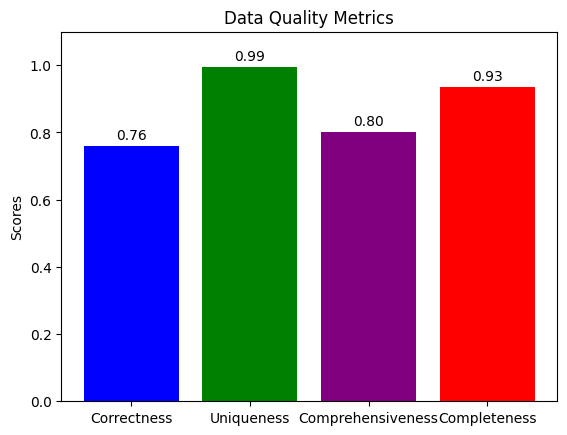

In [ ]:
import matplotlib.pyplot as plt

# Metrics values from the user
metrics = {
    'Correctness': 0.759,
    'Uniqueness': 0.995,
    'Comprehensiveness': 0.802,
    'Completeness':0.934
}

# Plotting the metrics
fig, ax = plt.subplots()
ax.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'purple', 'red'])
ax.set_title('Data Quality Metrics')
ax.set_ylabel('Scores')
ax.set_ylim(0, 1.1)  # Extend y-axis to fit labels
for i, v in enumerate(metrics.values()):
    ax.text(i, v + 0.02, f"{v:.2f}", ha='center', color='black')
plt.show()

**Improving Data quality metrics**

In [ ]:
import pandas as pd
import openai
from scipy.spatial.distance import cosine
from tqdm import tqdm  # Progress tracking

# Assign your OpenAI API key
openai.api_key = 'sk-proj-FFgXXrjrERWxO4z2XsjAT3BlbkFJAa2ZiweUp6plh5Kioaav'

# Set the definition of correctness
CORRECTNESS_DEFINITION = "Correctness evaluates the semantic alignment between the provided symptoms and the associated disease name. A higher alignment score suggests better correctness."

# Load the dataset
df = pd.read_csv('/content/MedRed_AMT_labels.csv')  # Update path accordingly

# Function to retrieve embeddings and calculate cosine similarity
def check_and_correct_alignment(symptoms, disease_name, engine="text-embedding-ada-002"):
    try:
        symptoms_emb = openai.Embedding.create(input=[symptoms], engine=engine)
        disease_emb = openai.Embedding.create(input=[disease_name], engine=engine)
        if symptoms_emb and disease_emb:
            score = 1 - cosine(symptoms_emb['data'][0]['embedding'], disease_emb['data'][0]['embedding'])
            if score < 1:
                return False  # Indicates that the current alignment is not perfect
            return True
    except Exception as e:
        print(f"Error in embedding or similarity calculation: {e}")
        return False

# Evaluate and correct records for perfect correctness
for index, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating and Correcting Entries"):
    if not check_and_correct_alignment(row['post'], row['subreddit']):
        # Prompting model to suggest a more suitable term
        prompt = f"{CORRECTNESS_DEFINITION}\n\nGiven the symptoms '{row['post']}', what would be a more suitable disease name?"
        try:
            result = openai.Completion.create(
                model="gpt-3.5-turbo-instruct",
                prompt=prompt,
                max_tokens=50,
                temperature=0.3
            )
            new_disease_name = result.choices[0].text.strip()
            df.loc[index, 'subreddit'] = new_disease_name  # Update the disease name in the dataframe
        except Exception as e:
            print(f"Failed to correct entry: {e}")

# Save the updated dataframe to a new CSV file
df.to_csv('/content/Updated_MedRed_AMT_labels.csv', index=False)

print("Updated CSV file saved. All entries have been corrected for maximum correctness.")


Evaluating and Correcting Entries:  47%|████▋     | 932/1976 [13:23<10:17,  1.69it/s]

Error in embedding or similarity calculation: We could not parse the JSON body of your request. (HINT: This likely means you aren't using your HTTP library correctly. The OpenAI API expects a JSON payload, but what was sent was not valid JSON. If you have trouble figuring out how to fix this, please contact us through our help center at help.openai.com.)


Evaluating and Correcting Entries: 100%|██████████| 1976/1976 [27:07<00:00,  1.21it/s]

Updated CSV file saved. All entries have been corrected for maximum correctness.


In [ ]:
import pandas as pd
import openai
from scipy.spatial.distance import cosine
from tqdm import tqdm  # Progress tracking

# Assign your OpenAI API key
openai.api_key = 'sk-proj-FFgXXrjrERWxO4z2XsjAT3BlbkFJAa2ZiweUp6plh5Kioaav'

# Set the definition of correctness
CORRECTNESS_DEFINITION = "Correctness evaluates the semantic alignment between the provided symptoms and the associated disease name. A higher alignment score suggests better correctness."

# Load the dataset
df = pd.read_csv('/content/Updated_MedRed_AMT_labels.csv')  # Update path accordingly

# Function to retrieve embeddings from a list of text items
def fetch_embeddings(texts, engine="text-embedding-ada-002"):
    try:
        result = openai.Embedding.create(input=texts, engine=engine)
        return [item['embedding'] for item in result['data']]
    except Exception as e:
        print(f"Failed to fetch embeddings: {e}")
        return [None] * len(texts)

# Function to check the contextual relevance of descriptions to diseases
def context_relevance_check(symptoms, disease_name):
    try:
        result = openai.Completion.create(
            model="gpt-3.5-turbo-instruct",
            prompt=f"{CORRECTNESS_DEFINITION}\n\nDoes the term '{disease_name}' relate contextually to the described symptoms '{symptoms}'? If not, provide a more suitable term.",
            max_tokens=50,
            temperature=0.3
        )
        return result.choices[0].text.strip()
    except Exception as e:
        print(f"Context check failed: {e}")
        return "Error"

# Evaluate correctness for each record in the dataset
correctness_scores = []
for _, entry in tqdm(df.iterrows(), total=len(df), desc="Evaluating correctness"):
    suitable_term = context_relevance_check(entry['subreddit'], entry['post'])
    symptoms_emb = fetch_embeddings([entry['subreddit']])
    disease_emb = fetch_embeddings([entry['post']])
    if symptoms_emb[0] and disease_emb[0]:
        score = 1 - cosine(symptoms_emb[0], disease_emb[0])
        correctness_scores.append(score)
    else:
        correctness_scores.append(None)

# Compute the average correctness score
valid_scores = [score for score in correctness_scores if score is not None]
average_correctness = sum(valid_scores) / len(valid_scores) if valid_scores else 0

# Output the correctness score and definition
print(f"Correctness Definition: {CORRECTNESS_DEFINITION}")
print(f"Average Correctness Score: {round(average_correctness, 4)}")


Evaluating correctness:  47%|████▋     | 933/1976 [17:50<18:34,  1.07s/it]

Failed to fetch embeddings: We could not parse the JSON body of your request. (HINT: This likely means you aren't using your HTTP library correctly. The OpenAI API expects a JSON payload, but what was sent was not valid JSON. If you have trouble figuring out how to fix this, please contact us through our help center at help.openai.com.)


Evaluating correctness: 100%|██████████| 1976/1976 [35:37<00:00,  1.08s/it]

Correctness Definition: Correctness evaluates the semantic alignment between the provided symptoms and the associated disease name. A higher alignment score suggests better correctness.
Average Correctness Score: 0.7768


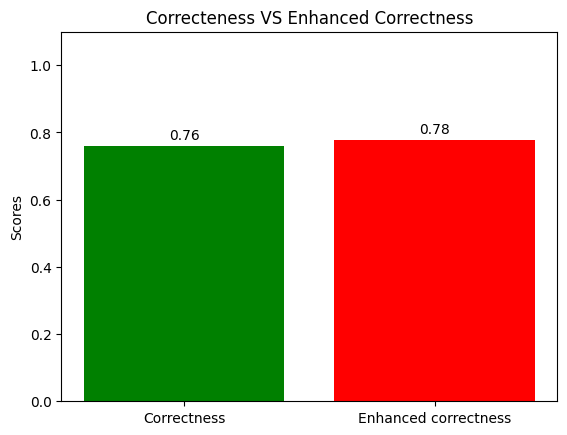

In [ ]:
import matplotlib.pyplot as plt

# Metrics values for correctness vs enhanced correctness
metrics = {
    'Correctness': 0.759,
    'Enhanced correctness': 0.7768
}

# Plotting the metrics
fig, ax = plt.subplots()
ax.bar(metrics.keys(), metrics.values(), color=['green', 'red'])
ax.set_title('Correcteness VS Enhanced Correctness')
ax.set_ylabel('Scores')
ax.set_ylim(0, 1.1)  # Extend y-axis to fit labels
for i, v in enumerate(metrics.values()):
    ax.text(i, v + 0.02, f"{v:.2f}", ha='center', color='black')
plt.show()